In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)


2.6.0


In [2]:
# Add metrics
def top_3_acc(y_true, y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, 3)


In [3]:
# Set parameter
nb_batch = 128
num_classes = 10
nb_epochs = 200
num_predictions = 20


In [4]:
# Set save model info
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)


In [5]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('x_train dtype:', x_train.dtype)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


x_train shape: (50000, 32, 32, 3)
x_train dtype: uint8
50000 train samples
10000 test samples


In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


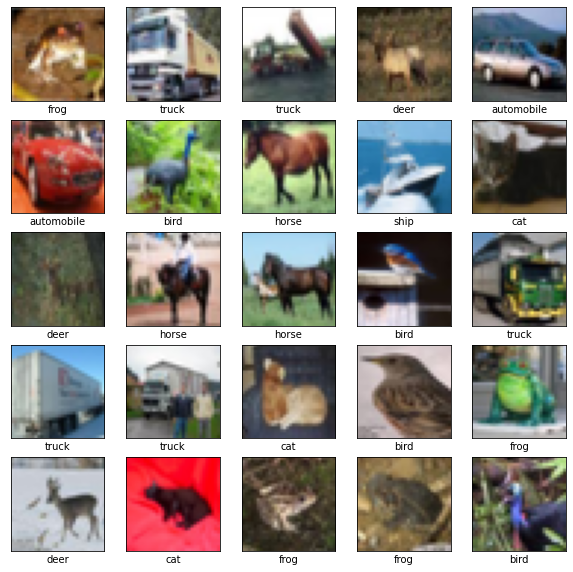

In [7]:
# 학습 이미지 확인
plt.figure(figsize=(10, 10), facecolor='white')
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i][0]])
plt.show()


In [8]:
# 전처리
AUTOTUNE = tf.data.AUTOTUNE

normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)
data_augmentation_layer = Sequential([
                            keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                            keras.layers.experimental.preprocessing.RandomRotation(0.1)
                        ])


def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets
    ds = ds.map(lambda x, y: (normalization_layer(x), y),
                num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Batch all datasets
    ds = ds.batch(nb_batch)

    # Use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation_layer(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefecting on all datasets
    return ds.prefetch(buffer_size=AUTOTUNE)


In [9]:
# 전처리
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_ds = prepare(train_ds, shuffle=True, augment=True)
test_ds = prepare(test_ds)


In [10]:
def getModel(dropout_rate=0.0):
    model = Sequential()
    model.add(Conv2D(32, [3, 3], padding='same',
              activation='relu', input_shape=x_train.shape[1:]))
    model.add(keras.layers.BatchNormalization())
    model.add(Conv2D(32, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(Conv2D(32, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(MaxPooling2D([2, 2], strides=(2, 2), padding='same'))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(64, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(Conv2D(64, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(Conv2D(64, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(MaxPooling2D([2, 2], strides=(2, 2), padding='same'))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(128, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(Conv2D(128, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(Conv2D(128, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(MaxPooling2D([2, 2], strides=(2, 2), padding='same'))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(256, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(Conv2D(256, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(Conv2D(256, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(MaxPooling2D([2, 2], strides=(2, 2), padding='same'))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(512, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(Conv2D(512, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(Conv2D(512, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(MaxPooling2D([2, 2], strides=(2, 2), padding='same'))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(1024, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(MaxPooling2D([2, 2], strides=(2, 2), padding='same'))
    model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(dropout_rate))

    # model.add(Dense(1024, activation='relu'))
    # model.add(Dropout(dropout_rate))

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    return model


In [11]:
def getModel2(dropout_rate=0.0):
    IMG_SIZE = 96
    
    base_model = keras.applications.ResNet50V2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                            weights='imagenet', 
                            include_top=False)
    base_model.trainable = False

    model = Sequential()
    model.add(keras.layers.Resizing(IMG_SIZE, IMG_SIZE, input_shape=x_train.shape[1:]))
    model.add(base_model)
    model.add(keras.layers.AveragePooling2D((2 ,2), strides=(1, 1), padding='same'))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dropout_rate)),
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [12]:
model = getModel(0.3)
# model = getModel2(0.3)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)       

In [13]:
# Compile
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])


In [14]:
# Restore weights
if os.path.isfile(model_path):
    # model.load_weights(model_path)
    # print('Weights load success.')
    pass

# Set callbacks
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=model_path, save_weights_only=True)

callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True,
                                         monitor='val_loss')


In [15]:
hist = model.fit(train_ds, batch_size=nb_batch, epochs=nb_epochs,
                 verbose=1, validation_data=test_ds,
                 shuffle=True,
                 callbacks=[checkpointer, callback])


Epoch 1/200
391/391 [==============================] - 20s 41ms/step - loss: 1.8327 - accuracy: 0.3131 - val_loss: 3.6540 - val_accuracy: 0.2025
Epoch 2/200
391/391 [==============================] - 15s 38ms/step - loss: 1.4819 - accuracy: 0.4567 - val_loss: 1.6234 - val_accuracy: 0.5243
Epoch 3/200
391/391 [==============================] - 15s 38ms/step - loss: 1.3225 - accuracy: 0.5379 - val_loss: 1.9626 - val_accuracy: 0.4949
Epoch 4/200
391/391 [==============================] - 15s 39ms/step - loss: 1.2130 - accuracy: 0.5809 - val_loss: 1.4490 - val_accuracy: 0.5867
Epoch 5/200
391/391 [==============================] - 15s 39ms/step - loss: 1.1365 - accuracy: 0.6166 - val_loss: 1.2132 - val_accuracy: 0.6109
Epoch 6/200
391/391 [==============================] - 15s 39ms/step - loss: 1.0681 - accuracy: 0.6404 - val_loss: 1.2344 - val_accuracy: 0.6130
Epoch 7/200
391/391 [==============================] - 15s 39ms/step - loss: 1.0090 - accuracy: 0.6610 - val_loss: 1.0405 - val_ac

In [16]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print('\nTest accuracy: {:.2f}%'.format(test_acc * 100))

# Modle1 Dropout 0.3 : 87.64%
# Model2 Dropout 0.3 : 79.73%
# 모델2 성능이 더 낮음...???


79/79 - 1s - loss: 0.3960 - accuracy: 0.8791

Test accuracy: 87.91%


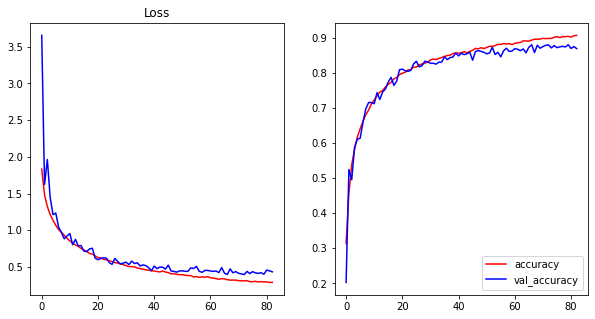

In [17]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], 'r-', label='loss')
plt.plot(hist.history['val_loss'], 'b-', label='val_loss')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], 'r-', label='accuracy')
plt.plot(hist.history['val_accuracy'], 'b-', label='val_accuracy')
plt.legend()
plt.show()


In [18]:
# 학습 결과 테스트를 이미지화 함수
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
               color=color)


def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


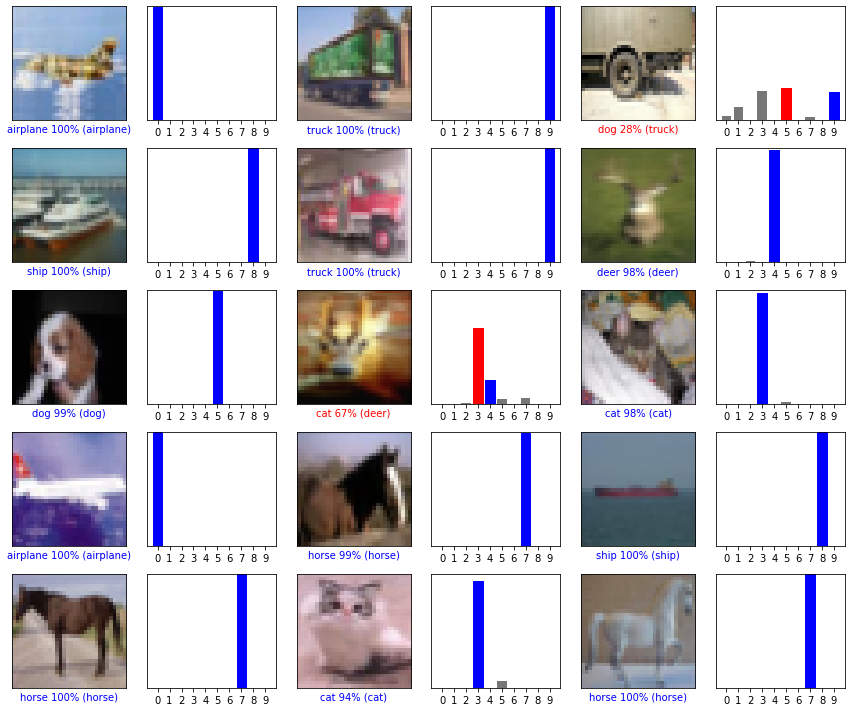

In [31]:
# 예측 결과 이미지화
test_iter = iter(test_ds.shuffle(nb_batch))
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

test_img_list, test_label_list = next(test_iter)

# Test 이미지 예측
predictions = model.predict(test_img_list)

for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_label_list, test_img_list)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_label_list)
plt.tight_layout()
plt.show()
